# Analysing Results

In [1]:
import gzip
import os

from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deephyper.analysis import rank
from deephyper.analysis._matplotlib import figure_size, update_matplotlib_rc

from lcdb.analysis import read_csv_results
from lcdb.analysis.plot import plot_learning_curves


update_matplotlib_rc()
figsize = figure_size(252 * 1.8, 1.0)

In [18]:
# source_csv = "output/lcdb.workflow.keras.DenseNNWorkflow/3/42-42-42/results.csv.gz"
source_csv = "output/lcdb.workflow.keras.DenseNNWorkflow/1461/42-42-42/results.csv.gz"

# Load a dataframe with the results
# The dataframe is sorted by `job_id` (increasing) as parallel jobs scheduled asynchronously 
# may be collected in a different order than when they were submitted.
with gzip.GzipFile(source_csv, "rb") as f:        
    r_df, r_df_failed = read_csv_results(f)
r_df

,p:activation,p:activity_regularizer,p:batch_norm,p:batch_size,p:bias_regularizer,p:dropout_rate,p:kernel_initializer,p:kernel_regularizer,p:learning_rate,p:num_layers,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
14,relu,none,False,32,none,0.100000,glorot_uniform,none,0.001000,5,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
56,softplus,L1L2,False,43,L1L2,0.641597,zeros,L1L2,0.000014,8,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
54,softmax,L1,True,24,L2,0.448968,he_uniform,L1L2,0.005425,20,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
10,relu,none,False,137,none,0.207282,random_uniform,none,0.000058,2,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
50,none,L1L2,False,229,none,0.415141,random_normal,L2,0.000486,20,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,tanh,L1,True,398,L1,0.689237,glorot_uniform,L1L2,0.038337,3,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
84,elu,none,False,46,none,0.797023,zeros,none,0.000072,5,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
93,relu,L1,False,22,L2,0.263812,orthogonal,none,1.161514,4,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
87,softsign,L1L2,False,2,L2,0.587637,zeros,L2,0.004561,15,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [19]:
r_df_failed

,p:activation,p:activity_regularizer,p:batch_norm,p:batch_size,p:bias_regularizer,p:dropout_rate,p:kernel_initializer,p:kernel_regularizer,p:learning_rate,p:num_layers,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
6,relu,L1,False,1,L1,0.724304,truncated_normal,L1,0.127907,14,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
9,tanh,L1L2,True,7,L1,0.216820,glorot_normal,L1L2,0.002160,20,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
15,softmax,L2,False,6,none,0.083964,random_uniform,L1,0.000668,13,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
16,none,L1L2,False,96,L1L2,0.701913,ones,none,6.759734,11,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
18,relu,L2,False,2,L1L2,0.749359,glorot_uniform,L1L2,0.030923,8,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
21,softplus,L2,False,1,L2,0.532664,zeros,L1L2,0.001012,13,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
22,softsign,L1L2,True,1,none,0.278584,orthogonal,L1L2,0.000730,5,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
23,selu,L1,True,2,none,0.833118,orthogonal,L1,0.008265,8,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
30,exponential,none,False,53,L1,0.859753,random_normal,L2,2.484548,7,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
36,relu,L1L2,False,5,none,0.635616,truncated_normal,none,5.514439,2,...,1461,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [20]:
print("Number of successful runs:", len(r_df))
print("Number of failed runs:", len(r_df_failed))

timestamp_start_experiment = min(r_df["m:timestamp_submit"].min(), r_df_failed["m:timestamp_submit"].min())
timestamp_end_experiement = min(r_df["m:timestamp_gather"].max(), r_df_failed["m:timestamp_gather"].max())
duration_experiment = timestamp_end_experiement - timestamp_start_experiment
print(f"Experiment duration: {duration_experiment} seconds")

Number of successful runs: 69
Number of failed runs: 31
Experiment duration: 3311.2523858547215 seconds


In [21]:
# Display the error of a failed job
idx = 0
print(r_df_failed.iloc[idx]["m:traceback"])

"Traceback (most recent call last):
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/utils.py", line 67, in terminate_on_timeout
    return results.get(timeout)
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/build/dhenv/lib/python3.10/multiprocessing/pool.py", line 770, in get
    raise TimeoutError
multiprocessing.context.TimeoutError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/controller.py", line 208, in fit_workflow_on_current_anchor
    self.workflow.fit(
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/utils.py", line 69, in terminate_on_timeout
    raise FunctionCallTimeoutError(f"Search timeout expired after: {timeout}")
lcdb.utils.FunctionCallTimeoutError: Search timeout expired after: 300
"


In [22]:
# Pre-made queries from LCDB
from lcdb.analysis.json import JsonQuery
from lcdb.analysis.json import QueryAnchorValues, QueryMetricValuesFromAnchors
from lcdb.analysis.json import QueryEpochValues, QueryMetricValuesFromEpochs
from lcdb.analysis.score import accuracy_from_confusion_matrix

In [23]:
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors("confusion_matrix", split_name="val")
out = source.apply(query_confusion_matrix_values)
accuracy_values = out.apply(lambda x: list(map(accuracy_from_confusion_matrix, x))).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, accuracy_values)):
    anchor_values[i] = xi[:len(yi)]

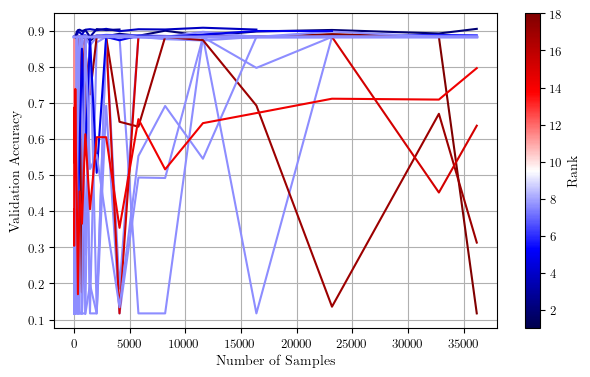

In [24]:
fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(anchor_values, accuracy_values, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Accuracy")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_accuracy_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

In [25]:
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_log_loss_values = QueryMetricValuesFromAnchors("log_loss", split_name="val")
log_loss_values = source.apply(query_log_loss_values).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, log_loss_values)):
    anchor_values[i] = xi[:len(yi)]

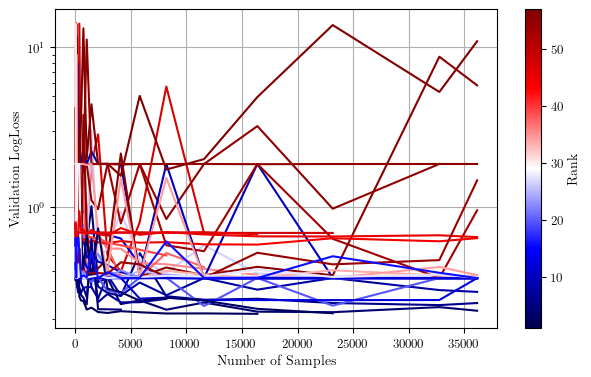

In [26]:
fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(anchor_values, log_loss_values, mode="min",  rank_method="dense", alpha=1.0, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation LogLoss")
ax.set_yscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_log_loss_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

In [27]:
source = r_df["m:json"]

# Query All Epochs and Keep Only Last Anchor
query_epoch_values = QueryEpochValues()
epoch_values = source.apply(lambda x: query_epoch_values(x)[-1]).to_list()

query_confusion_matrix_values = QueryMetricValuesFromEpochs(
    "confusion_matrix", split_name="val"
)
out = source.apply(lambda x: query_confusion_matrix_values(x)[-1])
accuracy_values = out.apply(
    lambda x: list(map(accuracy_from_confusion_matrix, x))
).to_list()

# Remove experiments which ended up with "NaN"
epoch_values, accuracy_values = list(
    zip(
        *[
            (xi, yi)
            for xi, yi in zip(epoch_values, accuracy_values)
            if len(xi) == len(yi) and len(xi) > 0
        ]
    )
)

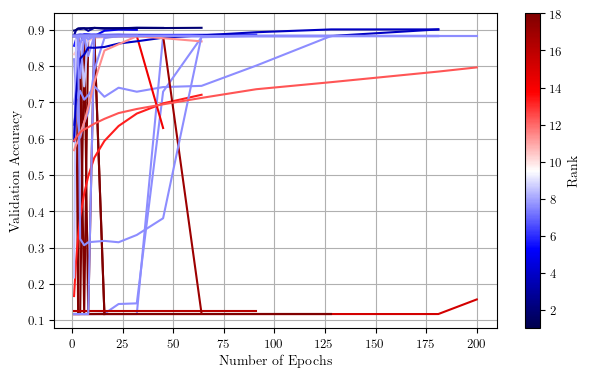

In [28]:
fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(epoch_values, accuracy_values, ax=ax)
ax.set_xlabel(f"Number of Epochs")
ax.set_ylabel(f"Validation Accuracy")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_accuracy_vs_epochs.jpg"), dpi=300, bbox_inches="tight")
plt.show()

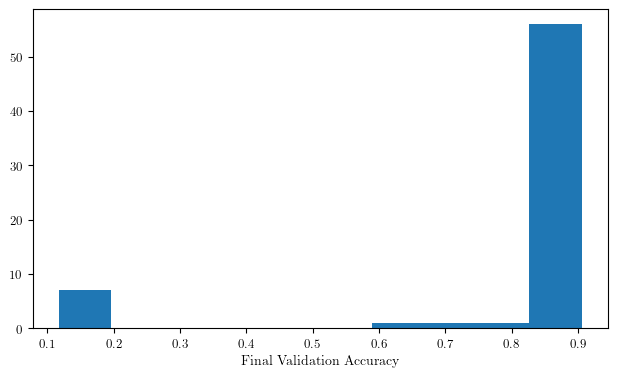

In [29]:
plt.figure(figsize=figsize)
x = [xi[-1] for xi in accuracy_values]
plt.hist(x, bins=10)
plt.xlabel("Final Validation Accuracy")
plt.show()

In [30]:
source = r_df["m:json"]

# Query All Epochs and Keep Only Last Anchor
query_epoch_values = QueryEpochValues()
epoch_values = source.apply(lambda x: query_epoch_values(x)[-1]).to_list()

query_log_loss_values = QueryMetricValuesFromEpochs(
    "log_loss", split_name="val"
)
log_loss_values = source.apply(lambda x: query_log_loss_values(x)[-1]).to_list()

# Remove experiments which ended up with "NaN"
epoch_values, log_loss_values = list(
    zip(
        *[
            (xi, yi)
            for xi, yi in zip(epoch_values, log_loss_values)
            if len(xi) == len(yi) and len(xi) > 0
        ]
    )
)

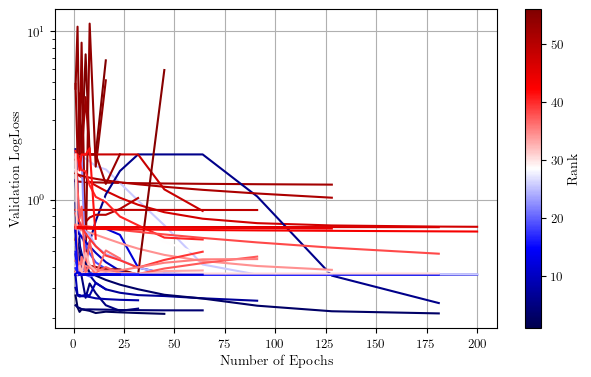

In [31]:
fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(epoch_values, log_loss_values, mode="min", rank_method="dense", alpha=1.0, ax=ax)
ax.set_xlabel(f"Number of Epochs")
ax.set_ylabel(f"Validation LogLoss")
ax.set_yscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_log_loss_vs_epochs.jpg"), dpi=300, bbox_inches="tight")
plt.show()